In [1]:
import sys
# This line adds the src directory to the path.
sys.path.append('../')  # Adjusts path to include the parent directory where data_pipeline is located


### Load the raw data into a PySpark Dataframe

In [10]:
%%time
"""Load data from a file and convert it to a PySpark DataFrame."""
    
FILE_PATH = '../../data/raw/amz_products_small.jsonl.gz'

from data_pipeline.etl import extract

df = extract.from_jsonl_gz_file(FILE_PATH)
data_size = df.count()
print(f"Data size: {data_size}")
distinct_categories_count = df.select('main_cat').distinct().count()
print(f"Total distinct main categories: {distinct_categories_count}")

df.groupBy('main_cat').count().show(n=30)


Data size: 1248417


Total distinct main categories: 22


+--------------------+-----+
|            main_cat|count|
+--------------------+-----+
|           Computers|67156|
|     All Electronics|52878|
|Home Audio & Theater|33401|
|        Pet Supplies|57490|
|        Toys & Games|72034|
|   Sports & Outdoors|70177|
|             Grocery|70184|
|         Video Games|21736|
|          Automotive|73434|
|               Books|69685|
|         Amazon Home|71362|
|Industrial & Scie...|55503|
|Health & Personal...|14116|
|Cell Phones & Acc...|59432|
|Arts, Crafts & Se...|72556|
|       Digital Music|48319|
|Tools & Home Impr...|74358|
|         Movies & TV|60608|
|     Office Products|71681|
|      Camera & Photo|36687|
|      Amazon Fashion|59747|
| Musical Instruments|35873|
+--------------------+-----+

CPU times: user 18.9 ms, sys: 18.7 ms, total: 37.6 ms
Wall time: 1min 37s


### Load the preprocessed data into a PySpark Dataframe

In [3]:
PREPROCESSED_FILE_PATH = '../data/preprocessed/amz_products_small_preprocessed_v1.parquet'

from src.training import utils
df = utils.read_parquet_to_pyspark(PREPROCESSED_FILE_PATH)

data_size = df.count()
print(f"Data size: {data_size}")
distinct_categories_count = df.select('main_cat').distinct().count()
print(f"Total distinct main categories: {distinct_categories_count}")

df.groupBy('main_cat').count().show(n=30)


24/06/21 08:46:46 WARN Utils: Your hostname, victor-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.0.162 instead (on interface wlp3s0)
24/06/21 08:46:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/21 08:46:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Data size: 1248417


Total distinct main categories: 22


+--------------------+-----+
|            main_cat|count|
+--------------------+-----+
|             Grocery|70184|
|          Automotive|73434|
|Health & Personal...|14116|
|     Office Products|71681|
|      Amazon Fashion|59747|
|Cell Phones & Acc...|59432|
|Tools & Home Impr...|74358|
|      Camera & Photo|36687|
|           Computers|67156|
|Home Audio & Theater|33401|
|         Amazon Home|71362|
|Industrial & Scie...|55503|
| Musical Instruments|35873|
|        Pet Supplies|57490|
|   Sports & Outdoors|70177|
|         Video Games|21736|
|       Digital Music|48319|
|         Movies & TV|60608|
|     All Electronics|52878|
|        Toys & Games|72034|
|               Books|69685|
|Arts, Crafts & Se...|72556|
+--------------------+-----+



### Plot the class distribution

/tmp/ipykernel_313074/2211235104.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='count', y='main_cat', data=pdf, palette='hsv')


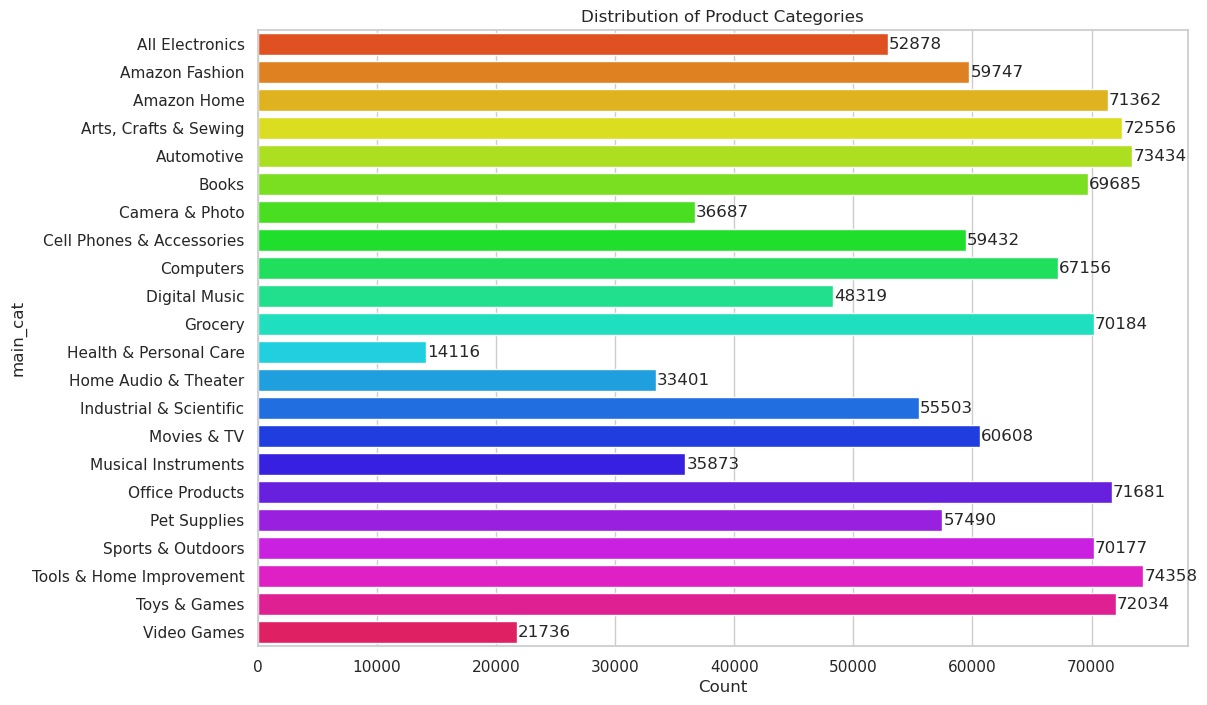

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

category_counts = df.groupBy('main_cat').count().orderBy('main_cat')
pdf = category_counts.toPandas()

# Setting the style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='count', y='main_cat', data=pdf, palette='hsv')

# Annotate each bar
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'),
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='center', va='center', xytext=(20, 0), textcoords='offset points')

# Set labels and title
plt.xlabel('Count')
plt.title('Distribution of Product Categories')

# Show plot
plt.show()

- No data on category "Buy a Kindle"
- Low ammount of amples for categories "Healt & Personal Care", "Home Audio & Theater", "Musical Instruments", "Video Games"
- ASIN is not a good feature to add to the text as it does not relate to its category. Just category "Books" had different start of ASIN.

### Analyse text length (distribution of data)

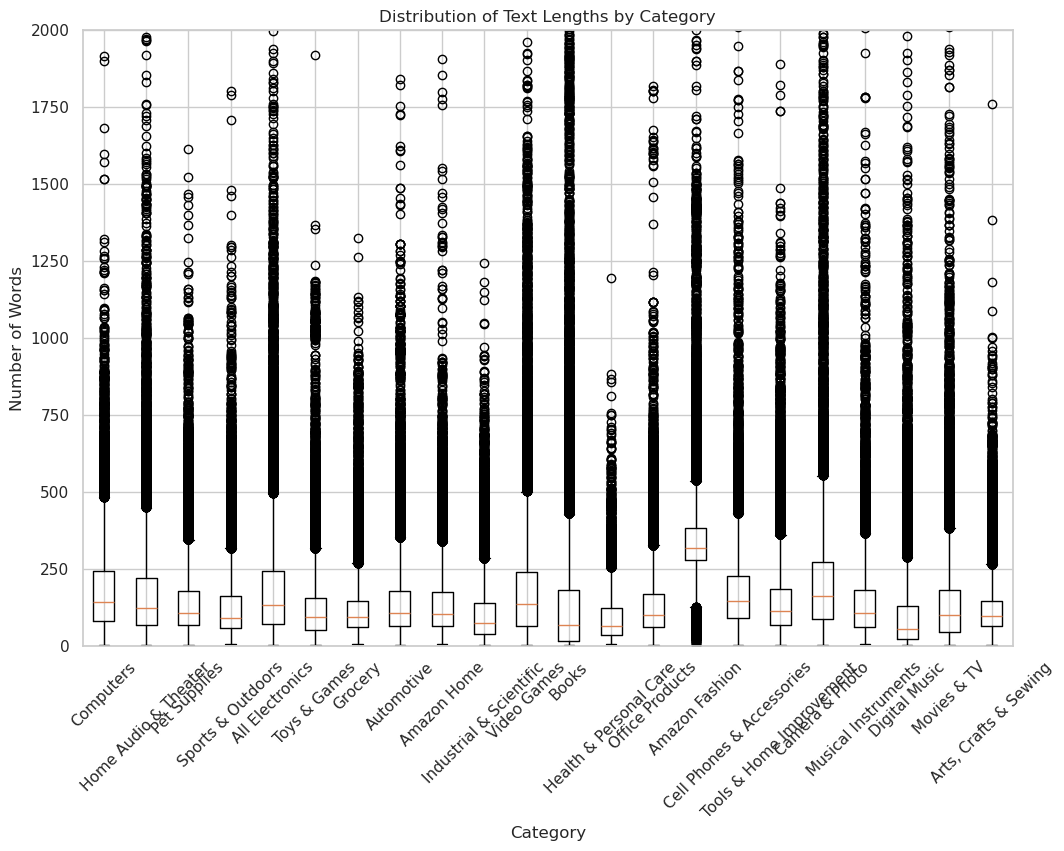

In [21]:
from pyspark.sql.functions import col, udf, collect_list
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt

# Define a UDF to calculate the number of words in a string
def count_words(text):
    return len(text.split())

count_words_udf = udf(count_words, IntegerType())


df = df.withColumn("num_words", count_words_udf(col("combined_text")))


data_to_plot = df.groupBy("main_cat").agg(collect_list("num_words").alias("words_per_cat")).collect()


# Prepare data for plotting
categories = [row['main_cat'] for row in data_to_plot]
words_lists = [row['words_per_cat'] for row in data_to_plot]

# Step 4: Creating the box plot
plt.figure(figsize=(12, 8))
plt.boxplot(words_lists, labels=categories)
plt.title('Distribution of Text Lengths by Category')
plt.xlabel('Category')
plt.ylabel('Number of Words')
plt.ylim(0, 2000)
plt.xticks(rotation=45)  # Rotate category labels for better readability
plt.grid(True)
plt.show()


- We see that the majority of the length for all the categories is below or slightly over 250 words. This is important because BERT Tokenizer will truncate the sentences to a maximum length of 512.
- The text is combined with the more relevant features at the beginning of the sentence so the tokenizer removes the least relevant part of the sentence.
- Alternative would be to generate a summary from the combined text of maximum 512 words.

### Check relevance of feature ASIN

In [16]:
from pyspark.sql.functions import col, collect_list, slice


"""Prints two examples of the ASIN value for each category.
"""

# Group by 'main_cat' and collect ASIN values into a list
grouped_df = df.groupBy("main_cat").agg(collect_list("asin").alias("asin_list"))


# Use `slice` to select the first two elements of the collected list
example_asins = grouped_df.withColumn("asin_examples", slice(col("asin_list"), 1, 2))

# Show the results
example_asins.select("main_cat", "asin_examples").show(truncate=False)

+-------------------------+------------------------+
|main_cat                 |asin_examples           |
+-------------------------+------------------------+
|Computers                |[B00006B6WM, B009KLHBG6]|
|All Electronics          |[B00004WHFF, B0000AX6DE]|
|Home Audio & Theater     |[B00000K3SI, B00005QY08]|
|Pet Supplies             |[B00205YXYC, B00279Z5TI]|
|Toys & Games             |[B00AK4LJ8I, B0001DKIKI]|
|Sports & Outdoors        |[B002917TG6, B00403D91A]|
|Grocery                  |[B00OA432G6, B0037YVGFE]|
|Video Games              |[B00000INRB, B0000AHRPN]|
|Automotive               |[B00ADZ3WUM, B005VII5IU]|
|Books                    |[0441547273, 0486209741]|
|Amazon Home              |[B00M9HPJYO, B004TD736I]|
|Industrial & Scientific  |[B0001MRTCE, B000A2BCT6]|
|Health & Personal Care   |[B00006I596, B00009K3O2]|
|Cell Phones & Accessories|[B01FZP0JAU, B017D5QAPS]|
|Arts, Crafts & Sewing    |[B00KQEBGQM, B00F0Z3L7E]|
|Digital Music            |[B00000K2TK, B00ODH

In [11]:
# Book ASINS look different from the rest of the categories


"""Prints ten examples of the ASIN value for book category.
"""

# Group by 'main_cat' and collect ASIN values into a list
book_asins = df.filter(df.main_cat == "Books").select("asin").limit(10).collect()


# Print the ASIN values
for row in book_asins:
    print(row["asin"])

0441547273
0486209741
160922017X
0312293275
1940242509
0764567985
1423451791
1574867067
1502595060
1453725385


In [18]:
from pyspark.sql.functions import col, collect_list, slice


"""Prints 10 examples of the price value for each category.
"""

# Group by 'main_cat' and collect ASIN values into a list
grouped_df = df.groupBy("main_cat").agg(collect_list("price").alias("price_list"))


# Use `slice` to select the first two elements of the collected list
example_prices = grouped_df.withColumn("price_examples", slice(col("price_list"), 1, 10))

# Show the results
example_prices.select("main_cat", "price_examples").show(n=30, truncate=False)

+-------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [19]:
from pyspark.sql.functions import col, collect_list, slice


"""Prints 10 examples of the image url value for each category.
"""

# Group by 'main_cat' and collect ASIN values into a list
grouped_df = df.groupBy("main_cat").agg(collect_list("image").alias("image_list"))


# Use `slice` to select the first two elements of the collected list
example_images = grouped_df.withColumn("image_examples", slice(col("image_list"), 1, 10))

# Show the results
example_images.select("main_cat", "image_examples").show(n=30, truncate=False)

+-------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
spark.stop()